In [1]:
import sys
import os

os.chdir('/home/twhit/bliss')

import torch
import numpy as np
from os import environ
from pathlib import Path
from hydra import initialize, compose
from hydra.utils import instantiate
import matplotlib.pyplot as plt
from omegaconf import DictConfig, OmegaConf
from bliss.catalog import TileCatalog

In [2]:
environ["BLISS_HOME"] = "/home/twhit/bliss"
with initialize(config_path=".", version_base=None):
    cfg = compose("lensing_config", overrides={"surveys.sdss.load_image_data=true"})

In [3]:
def generate(gen_cfg: DictConfig):
    simulated_dataset = instantiate(gen_cfg.simulator, num_workers=0)

    for _ in range(1):
        batch = simulated_dataset.get_batch()
        
    return batch

In [4]:
batch = generate(cfg.generate)

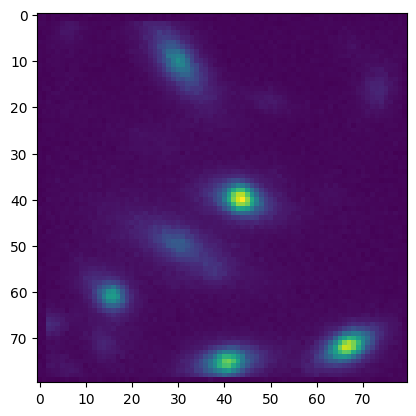

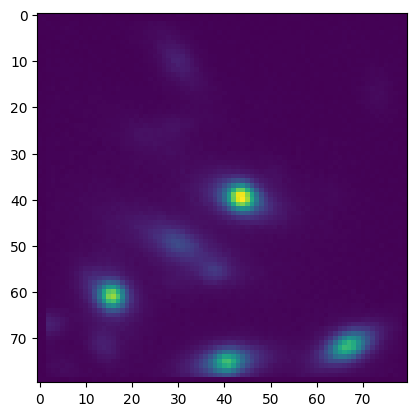

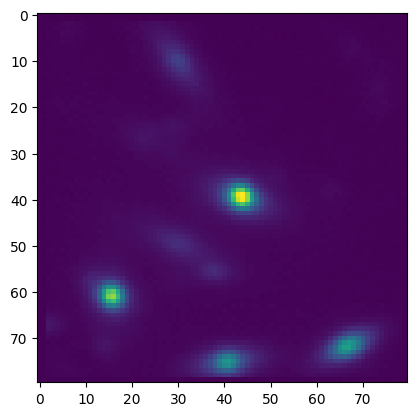

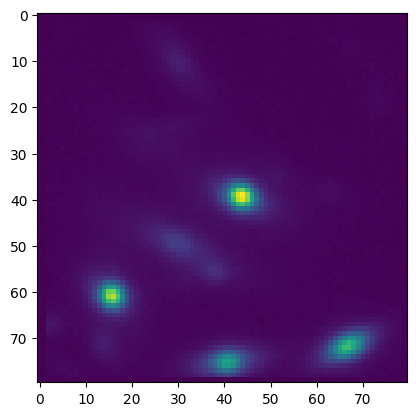

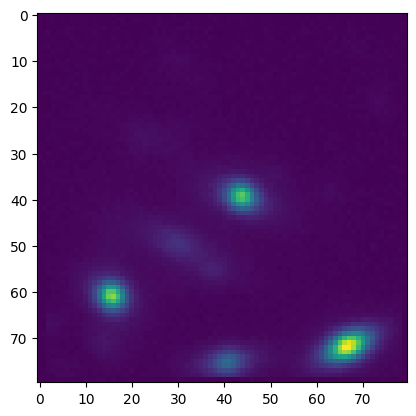

In [5]:
for j in range(5):
    fig, plot = plt.subplots(nrows=1,ncols=1)
    plot.imshow(batch['images'][0][j])